# A comparison of 10k cohort thrombolysis rates across hospitals, and comparison with hospital SHAP values

## Plain English summary

In response to stroke teams being told that they are performing differently from other, they often state that this is due to them having a different set of patients.

This does have some truth to it. For example the hospitals in London will have younger patients, arriving sooner than compared to hospitals in more rural locations.

In order to remove patient differences from results, a common 10k cohort of patients will be used with each of the hospital models. That way any difference is due to hospital factors, and not patient factors.

The predicted thrombolysis use in the 10k cohort of patients ranged from 10% to 45% across the 132 hospitals. The size of the hospital only accounted for 10% of the variation in thrombolysis use, and so there are other factors that account for the remaining 90%.

## Model and data

An XGBoost model is trained on all but a 10k patient cohort, to predict which patient will recieve thrombolysis.The 10k patient cohort is then used in two ways: 1) as the test set for the model fitting process, and 2) as a common set of patients that are sent to each hospital in turn to obtain a thrombolysis rate that is comparable across hosptials which has any patient factors removed.

The XGBoost model is fitted to all but 10k instances, and uses 8 features: 

* Arrival-to-scan time: Time from arrival at hospital to scan (mins)
* Infarction: Stroke type (1 = infarction, 0 = haemorrhage)
* Stroke severity: Stroke severity (NIHSS) on arrival
* Precise onset time: Onset time type (1 = precise, 0 = best estimate)
* Prior disability level: Disability level (modified Rankin Scale) before stroke
* Stroke team: Stroke team attended
* Use of AF anticoagulents: Use of atrial fibrillation anticoagulant (1 = Yes, 0 = No)
* Onset-to-arrival time: Time from onset of stroke to arrival at hospital (mins)

And one target feature:
* Thrombolysis: Recieve thrombolysis (1 = Yes, 0 = No)

The 8 features included in the model (to predict whether a patient will recieve thrombolysis) were chosen sequentially as having the single best improvement in model performance (using the ROC AUC). The stroke team feature is included as a one-hot encoded feature.

## Aims:

* Train XGBoost model on all data except for a 10k set of patients
* Predict use of thrombolysis in the heldback 10k cohort of patients, at each of the 132 hospitals (by changing hospital one-hot coding).
* Compare the thrombolysis rate across the 132 hospitals. This can be seen as comparing the hospital effect, as the patient factors have been removed.
* Save thrombolysis rate at each hospital for the 10k patient cohort (for use in next notebook).
* Compare level of agreement between hospitals. How many hospitals agree on whether to give each patient in the 10k cohort thrombolysis, or not.
* Compare thrombolysis rate of 10k cohort with real unit size.
* Calculate the SHAP values and SHAP interactions for the 10k patients attending each of the 132 hospitals.
* Compare the average hosptial SHAP value, and average hospital SHAP main effect, across the 132 hospitals.

## Observations
* The 10k cohort model had an accuracy of 84.1%, in line with accuracy from k-fold testing (84.7%, see notebook 02).
* Thrombolysis rate with the hosptials own patients ranged from 6% to 48%, whereas the predicted thrombolysis use in the 10k cohort of patients ranged from 10% to 45%.
* Thrombolysis rate of 10k cohort correlates weakly with unit size: only 10% of the variability in 10k hospital thrombolysis rate can be explained by the hospital admission rate.
* Hospital SHAP values range from -2 to 3, hospital SHAP main effect values range from -1.5 to 1.5, showing that hospitals have a different disposition to giving thrombolysis.
* 10k thrombolysis rate correlates closely with average hospital SHAP value: 93% of the variability in 10k hospital thrombolysis rate can be explained by the average hospital SHAP value.
* 10k thrombolysis rate correlates closely with average hospital SHAP main effect value: nearly 95% of the variability in 10k hospital thrombolysis rate can be explained by the average hospital SHAP value.
 
It is easier to find majority agreement on who not to thrombolyse than who to thrombolyse. For example:
 * 87.4% of all patients have a treatment decision that is agreed by 80% hospitals
 * Of those who were not given thrombolysis, 91.1% had agreement by 80% hospitals
 * Of those who were given thrombolysis, 78.7% had agreement by 80% hospitals

## Import libraries

In [1]:
# Turn warnings off to keep notebook tidy
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
import shap
import copy

from scipy import stats

import pickle

from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.linear_model import LinearRegression

from xgboost import XGBClassifier

from os.path import exists
import json

## Set filenames

In [2]:
number_key_features = 8
model_text = f'xgb_{number_key_features}_features_10k_cohort'
notebook = '04'

## Create output folders if needed

In [3]:
path = './saved_models'
if not os.path.exists(path):
    os.makedirs(path)
    
path = './output'
if not os.path.exists(path):
    os.makedirs(path)
    
path = './predictions'
if not os.path.exists(path):
    os.makedirs(path)

## Read in JSON file

Contains a dictionary for plain English feature names for the 8 features selected in the model. Use these as the column titles in the DataFrame.

In [4]:
with open("./output/01_feature_name_dict.json") as json_file:
    dict_feature_name = json.load(json_file)

## Load data

10k cohort of patients in test data, rest in training data

In [5]:
data_loc = '../data/10k_training_test/'

In [6]:
# Load data
train = pd.read_csv(data_loc + 'cohort_10000_train.csv')
test = pd.read_csv(data_loc + 'cohort_10000_test.csv')

# Read in the names of the selected features for the model
number_of_features_to_use = 8
key_features = pd.read_csv('./output/01_feature_selection.csv')
key_features = list(key_features['feature'])[:number_of_features_to_use]
# And add the target feature name: S2Thrombolysis
key_features.append('S2Thrombolysis')

# Select features
train = train[key_features]
train.rename(columns=dict_feature_name, inplace=True)
test = test[key_features]
test.rename(columns=dict_feature_name, inplace=True)

### Calculate the number of admissions to each stroke team, and their thrombolysis rate

For their own patients

In [7]:
# Get relevant columns from train and test set
train_stroke_team_ivt = train[['Stroke team', 'Thrombolysis']]
test_stroke_team_ivt = test[['Stroke team', 'Thrombolysis']]

# Join data
df_stroke_team_own_individual_patients = pd.concat(
                        [test_stroke_team_ivt, train_stroke_team_ivt], 
                        axis=0, ignore_index=True)

# Calculate admissions for each stroke team for their own patients
admissions = (
    df_stroke_team_own_individual_patients.groupby('Stroke team').count())
admissions.rename(columns={'Thrombolysis':'Admissions'}, inplace=True)
# Calculate thrombolysis rate for each stroke team, for their own patients
thrombolysis_rate = (
        df_stroke_team_own_individual_patients.groupby('Stroke team').mean
                                                            ('Thrombolysis'))
thrombolysis_rate.rename(columns={'Thrombolysis':'Thrombolysis rate'}, 
                         inplace=True)

# Join data
df_stroke_team_own_patients = pd.concat(
                        [thrombolysis_rate, admissions], axis=1)

In [8]:
df_stroke_team_own_patients

,Thrombolysis rate,Admissions
Stroke team,,
AGNOF1041H,0.352468,871
AKCGO9726K,0.369748,1428
AOBTM3098N,0.218803,585
APXEE8191H,0.226481,574
ATDID5461S,0.240385,312
...,...,...
YPKYH1768F,0.246057,317
YQMZV4284N,0.236170,470
ZBVSO0975W,0.250000,432


## Fit XGBoost model

Fit XGBoost model on the 10k cohort train/test dataset, and calculate model accuracy.

Save models.

In [9]:
# Fit models (True), or load models (False)
fit_models = False

# Get X and y
X_train = train.drop('Thrombolysis', axis=1)
X_test = test.drop('Thrombolysis', axis=1)
y_train = train['Thrombolysis']
y_test = test['Thrombolysis']

# One hot encode hospitals
X_train_hosp = pd.get_dummies(X_train['Stroke team'], prefix = 'team')
X_train = pd.concat([X_train, X_train_hosp], axis=1)
X_train.drop('Stroke team', axis=1, inplace=True)
X_test_hosp = pd.get_dummies(X_test['Stroke team'], prefix = 'team')
X_test = pd.concat([X_test, X_test_hosp], axis=1)
X_test.drop('Stroke team', axis=1, inplace=True)    

filename = (f'./saved_models/{notebook}_{model_text}.p')

# Fit model
if fit_models:
    # Define model
    model = XGBClassifier(verbosity=0, seed=42, learning_rate=0.5)
    model.fit(X_train, y_train)

    # Save using pickle
    with open(filename, 'wb') as filehandler:
        pickle.dump(model, filehandler)
else:
    # Load models
    with open(filename, 'rb') as filehandler:
        model = pickle.load(filehandler)

# Get predicted probabilities and class
y_prob = model.predict_proba(X_test)[:,1]
y_pred = model.predict(X_test)

# Show accuracy
accuracy = np.mean(y_pred == y_test)
print (f'Accuracy: {accuracy:.3f}')

Accuracy: 0.841


Calculate receiver operating characteristic curve area under curve.

In [10]:
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
print (f'ROC ACUC: {roc_auc:.3f}')

ROC ACUC: 0.913


## Pass 10k cohort through all hospital models to get the 10k cohort thrombolysis rate for each hospital

For each hospital, set all of the 10k patients in the test set as attending that hospital, and calculate the thrombolysis rate. This will give a thrombolysis rate for each hospital with patient variation removed, and only hospital factors remaining.

Get list of unique stroke teams, in alphabetical order

In [11]:
hospitals = list(set(train['Stroke team']))
hospitals.sort()

In [12]:
# Initialise empty lists
thrombolysis_rate = []
single_predictions = []

# For each hospital
for hospital in hospitals:
    
    # Get test data without thrombolysis hospital or stroke team
    X_test_no_hosp = test.drop(['Thrombolysis', 'Stroke team'], axis=1)
    
    # Copy hospital dataframe and change hospital ID (after setting all to zero)
    X_test_adjusted_hospital = X_test_hosp.copy()
    X_test_adjusted_hospital.loc[:,:] = 0
    team = "team_" + hospital
    X_test_adjusted_hospital[team] = 1
    
    X_test_adjusted = pd.concat(
        [X_test_no_hosp, X_test_adjusted_hospital], axis=1)
    
    # Get predicted probabilities and class
    y_prob = model.predict_proba(X_test_adjusted)[:,1]
    y_pred = model.predict(X_test_adjusted)
    thrombolysis_rate.append(y_pred.mean())
    
    # Save predictions
    single_predictions.append(y_pred * 1)

In [13]:
# Convert individual predictions (list of arrays) to a NumPy array, transpose.
patient_results = np.array(single_predictions).T

# Convert to DataFrame
df_10k_patient_results = pd.DataFrame(patient_results)
df_10k_patient_results.to_csv(f'./output/{notebook}_{model_text}_individual_'
                       f'predictions.csv', 
                       index=False)

del patient_results

Sort by hospital 10k thrombolysis rate.

In [14]:
df_10k_thrombolysis_by_hosp = pd.DataFrame(index=hospitals)
df_10k_thrombolysis_by_hosp['Thrombolysis rate'] = thrombolysis_rate
df_10k_thrombolysis_by_hosp.sort_values(
    'Thrombolysis rate', inplace=True, ascending=False)

# Save
df_10k_thrombolysis_by_hosp.to_csv(
    f'./output/{notebook}_{model_text}_thrombolysis_rate_by_hosp.csv', 
    index_label='stroke_team')

### Plot histogram of 10k cohort thrombolysis rate at each hospital

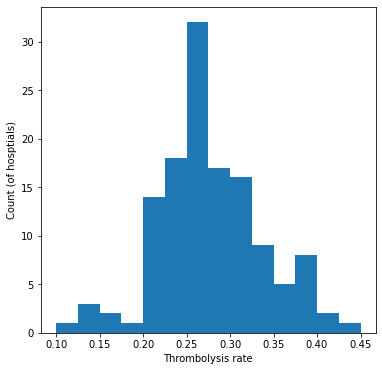

In [15]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot()
ax.hist(thrombolysis_rate, bins=np.arange(0.10, 0.46, 0.025))
ax.set_xlabel('Thrombolysis rate')
ax.set_ylabel('Count (of hosptials)')

plt.savefig(
    f'./output/{notebook}_{model_text}_thrombolysis_rate_by_hosp.jpg', 
    dpi=300)

plt.show()

### How does the 10k cohort hospital thrombolysis rate compare with the hosptials thrombolysis rate on their own patients?

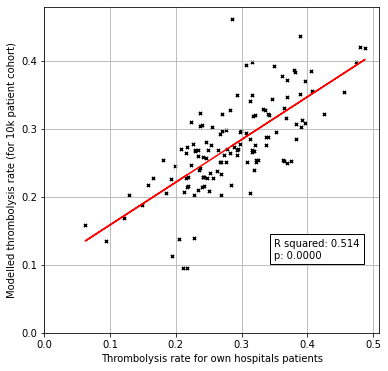

In [16]:
# Join dataframes together (on index)
df_data_to_plot = df_10k_thrombolysis_by_hosp.join(
                            df_stroke_team_own_patients["Thrombolysis rate"], 
                            lsuffix=' 10k', rsuffix=' own')

# Setup data for chart
x = np.array(df_data_to_plot['Thrombolysis rate own']).reshape(-1, 1)
y = np.array(df_data_to_plot['Thrombolysis rate 10k']).reshape(-1, 1)

# Fit a regression line to the points
slope, intercept, r_value, p_value, std_err = \
    stats.linregress(x.flatten(),y.flatten())
r_square = r_value ** 2
y_pred = intercept + (x * slope)

# Create scatter plot with regression line
fig = plt.figure(figsize=(6,6))
ax1 = fig.add_subplot(111)
ax1.scatter(x, y, color='black', marker='x', s=10)
plt.plot (x, y_pred, color = 'red')
text = f'R squared: {r_square:.3f}\np: {p_value:0.4f}'
ax1.text(0.35, 0.11, text, 
         bbox=dict(facecolor='white', edgecolor='black'))
ax1.set_xlabel('Thrombolysis rate for own hospitals patients')
ax1.set_ylabel('Modelled thrombolysis rate (for 10k patient cohort)')

# Force axis start at 0
ax1.set_xlim(0, ax1.get_xlim()[1])
ax1.set_ylim(0, ax1.get_ylim()[1])
plt.grid()
plt.savefig(
    f'./output/{notebook}_{model_text}_hospital_thrombolysis_10k_vs_own.jpg', 
    dpi=300)

plt.show()

### How does the 10k cohort hospital thrombolysis rate compare with the hospital size (admissions) of their own patients?

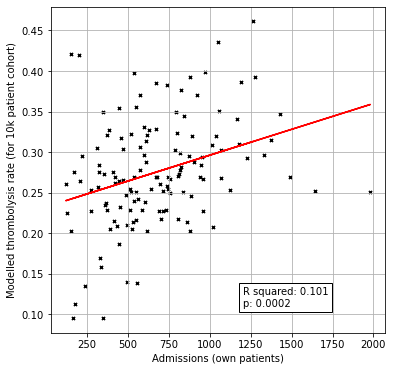

In [17]:
# Join dataframes together (on index)
df_data_to_plot = df_10k_thrombolysis_by_hosp.join(
                                    df_stroke_team_own_patients["Admissions"])

# Setup data for chart
x = np.array(df_data_to_plot['Admissions']).reshape(-1, 1)
y = np.array(df_data_to_plot['Thrombolysis rate']).reshape(-1, 1)

# Fit a regression line to the points
slope, intercept, r_value, p_value, std_err = \
    stats.linregress(x.flatten(),y.flatten())
r_square = r_value ** 2
y_pred = intercept + (x * slope)

# Create scatter plot with regression line
fig = plt.figure(figsize=(6,6))
ax1 = fig.add_subplot(111)
ax1.scatter(x, y, color='black', marker='x', s=10)
plt.plot (x, y_pred, color = 'red')
text = f'R squared: {r_square:.3f}\np: {p_value:0.4f}'
ax1.text(1200, 0.11, text, 
         bbox=dict(facecolor='white', edgecolor='black'))
ax1.set_xlabel('Admissions (own patients)')
ax1.set_ylabel('Modelled thrombolysis rate (for 10k patient cohort)')
plt.grid()
plt.savefig(
    f'./output/{notebook}_{model_text}_hospital_own_size_vs_10k_thrombolysis.jpg', 
    dpi=300)

plt.show()

### Show stats of 10k cohort thrombolyiss rate for each hospital

In [18]:
mean = np.mean(df_10k_thrombolysis_by_hosp['Thrombolysis rate'])
stdev = np.std(df_10k_thrombolysis_by_hosp['Thrombolysis rate'])
minimum = np.min(df_10k_thrombolysis_by_hosp['Thrombolysis rate'])
maximum = np.max(df_10k_thrombolysis_by_hosp['Thrombolysis rate'])

print (f'Mean: {mean:0.3f}')
print (f'StDev: {stdev:0.3f}')
print (f'Min: {minimum:0.3f}')
print (f'Max{maximum:0.3f}')

Mean: 0.275
StDev: 0.067
Min: 0.096
Max0.461


## Compare level of agreement between hospitals 

In this section we look at how many hospitals agree on whether to give each patient in the 10k cohort thrombolysis or not.

Collating individual predictions:

In [19]:
# Set up dataframe with row for each of the 10k patient, with number and 
#   percent of hospitals giving them thrombolysis
df_agreement = pd.DataFrame()
df_agreement['sum'] = df_10k_patient_results.sum(axis=1)
df_agreement['percent'] = (
                    df_agreement['sum'] * 100 / df_10k_patient_results.shape[1])

# Percent agree (amongst the 132 hosptials, whichever is the dominant decision, 
#   to give or ot, what proportion of the hosapitals agreed). This can be to 
#   give thrombolysis (p) or not (100-p)
df_agreement['percent_agree'] = [max(p, 100-p) for p in df_agreement['percent']]

# Add in whether thrombolysis was actually given by the attended hospital
df_agreement['True'] = y_test

Plot results:

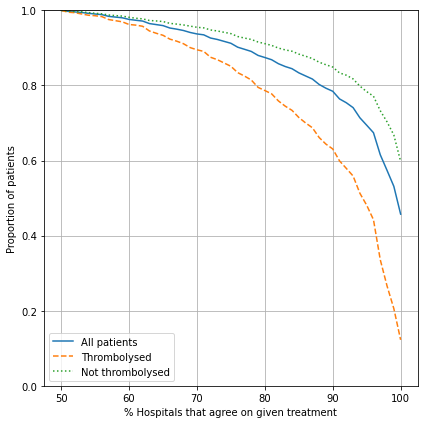

In [20]:
fig = plt.figure(figsize=(6,6))

# Agreement on treatment 
ax1 = fig.add_subplot(111)
xvals = np.arange(50,101,1)

y1 = [sum([1 for p in df_agreement.percent_agree.values if p>=x])\
         /len(df_agreement.percent_agree.values) for x in xvals]

ax1.plot(xvals, y1, label='All patients', linestyle='-')

y2 = (
 [sum(1 for p in df_agreement[df_agreement['True']==1].percent_agree.values if p>=x)\
 /len(df_agreement[df_agreement['True']==1].percent_agree.values) for x in xvals])

ax1.plot(xvals, y2, label='Thrombolysed', linestyle='--')

y3 = (
  [sum(1 for p in df_agreement[df_agreement['True']==0].percent_agree.values if p>=x)\
  /len(df_agreement[df_agreement['True']==0].percent_agree.values) for x in xvals])
      
ax1.plot(xvals, y3, label='Not thrombolysed', linestyle=':')
         
ax1.legend()

ax1.set_xlabel('% Hospitals that agree on given treatment')
ax1.set_ylabel('Proportion of patients')
ax1.set_ylim(0, 1)
ax1.grid()
      
plt.tight_layout()
plt.savefig(
        f'./output/{notebook}_{model_text}_agreement_vs_hospital_single.jpg', 
        dpi=300)
plt.show()

Show statistics:

In [21]:
# Set percent of hospital to agree
xvals = [80, 90, 95]

# Find proportion of patients with agreement for either treat/no-treat decsion
agree_all = [sum([1 for p in df_agreement.percent_agree.values if p>=x])\
         /len(df_agreement.percent_agree.values) for x in xvals]

# Find proportion of thrombolysed patients with agreement
agree_thromb = [
  sum(1 for p in df_agreement[df_agreement['True']==1].percent_agree.values if p>=x)\
  /len(df_agreement[df_agreement['True']==1].percent_agree.values) for x in xvals]

# Find proportion of non-thrombolysed patients with agreement
agree_non_thromb = [
  sum(1 for p in df_agreement[df_agreement['True']==0].percent_agree.values if p>=x)\
  /len(df_agreement[df_agreement['True']==0].percent_agree.values) for x in xvals]

# Put in DataFrame
results_agree = pd.DataFrame()
results_agree['% Hospitals Agree'] = xvals
results_agree.set_index('% Hospitals Agree', inplace=True)
results_agree['Any'] = agree_all
results_agree['Patient thrombolysed'] = agree_thromb
results_agree['Patient not thrombolysed'] = agree_non_thromb
results_agree = results_agree.round(3)

results_agree

,Any,Patient thrombolysed,Patient not thrombolysed
% Hospitals Agree,,,
80,0.874,0.787,0.911
90,0.785,0.631,0.849
95,0.694,0.481,0.784


In the table above, for example, 87.4% of patients have 80% of hospitals agree on treatment. For those patients that did actually receive thrombolysis, 78.8% of patients have 80% of hospitals agree to thrombolyse. For those patients that did not actually receive thrombolysis, 91.1% of patients have 80% of hospitals agree not to thrombolyse. 

## Shap value and SHAP main effect

SHAP values are calculated for each feature for each patient. Each SHAP value can be represented as the sum of it's main effect and each of it's pair-wise feature interactions. 

In our model, the hospital feature is one hot encoded, so there is a SHAP value (and SHAP main effect) for each stroke team, for each of the 10k patient cohort.

We can look at the values for the hospital one-hot encoded feature for the attended hosptial and compare it with the predicted 10k thrombolysis rate.

We will create two plots:
1) histogram of the frequency of the SHAP value (and main effect) for the attended one-hot encoded hospital feature
2) scatter plot of SHAP value (and main effect) vs 10k cohort thrombolysis rate for each hospital

### Get SHAP values

Either set up method to estimate SHAP values, or if already created then load from pickle.

In [22]:
%%time

# Set up method to estimate SHAP values for tree models and ensembles of trees
filename = (f'./output/{notebook}_{model_text}_shap_explainer_'
            f'object.p')
file_exists = exists(filename)

if file_exists:
    # Load SHAP explainer
    with open(filename, 'rb') as filehandler:
        explainer = pickle.load(filehandler)
else:
    # Get SHAP explainer (using the model and feature values from training set)
    explainer = shap.TreeExplainer(model, X_train)
    # Save using pickle
    with open(filename, 'wb') as filehandler:
        pickle.dump(explainer, filehandler)

CPU times: user 11.2 ms, sys: 4.03 ms, total: 15.2 ms
Wall time: 14.7 ms


Calculate SHAP value for each patient in the 10k cohort, per feature, per hospital. Store in a dictionary using the hospital name as the dictionary key.

In [23]:
# Initialise dictionary to store shap_values per hospital.
dict_shap_values_extended = {}

# Get SHAP values
filename = (f'./output/{notebook}_{model_text}_dict_shap_values_'
            f'explainer_object.p')
file_exists = exists(filename)

if file_exists:
    # Load SHAP values (in a dictionary, using hospital as a key
    with open(filename, 'rb') as filehandler:
        dict_shap_values_extended = pickle.load(filehandler)
else:
    # For each hospital calculate SHAP values for the 10k cohort
    count = 0
    for hospital in hospitals:
        # Print progress
        count += 1
        print (f"Calculating SHAP for hospital {count} of {len(hospitals)}")
        
        # Get 10k data without thrombolysis hospital or stroke team
        X_test_no_hosp = test.drop(['Thrombolysis', 'Stroke team'], axis=1)

        # Copy hospital dataframe, change hospital ID after setting all to zero
        X_test_adjusted_hospital = X_test_hosp.copy()
        X_test_adjusted_hospital.loc[:,:] = 0
        team = "team_" + hospital
        X_test_adjusted_hospital[team] = 1

        X_test_adjusted = pd.concat(
            [X_test_no_hosp, X_test_adjusted_hospital], axis=1)

        # Get SHAP values (along with base and feature values)
        shap_values_extended = explainer(X_test_adjusted)
        
        # Add to overall shap_values_extended
        dict_shap_values_extended[f"{hospital}"] = shap_values_extended
        
    # Save the shap_values+extended dictionary
    with open(filename, 'wb') as filehandler:
        pickle.dump(dict_shap_values_extended, filehandler)

#### Format the SHAP values data

SHAP values are in the same features order as they are in the original dataset. Use this fact to extract the SHAP values for the one-hot encoded hospital features. Create a dataframe containing the SHAP values: an instance per row, and a one-hot encoded hospital feature per column.

Add four further columns:
* the Stroke team that each instance attended
* contribution from all the hospital features
* contribution from the attended hospital
* contribution from not attending the rest

In [24]:
#save
filename = f'./output/{notebook}_{model_text}_SHAP_values.csv'
file_exists = exists(filename)

if file_exists:
    df_hosp_shap_values = pd.read_csv(filename)
else:
    # Get list of hospital one hot encoded column titles
    hospitals_ohe = X_test.filter(regex='^team',axis=1).columns
    n_hospitals = len(hospitals_ohe)

    # Create list of column index for these hospital column titles
    hospital_columns_index = [X_test.columns.get_loc(col) for col in hospitals_ohe]

    # Create column titles
    columns = copy.deepcopy(hospitals)
    columns.append("Stroke team")
    columns.append("All stroke teams")
    columns.append("Attended stroke team")
    columns.append("Not attended stroke teams")

    # Initialise empty dataframe with these titles
    df_hosp_shap_values = pd.DataFrame(columns=columns)

    # For each hospital
    for hospital in hospitals:
    #    print (f"Joining SHAP for hospital {count} of {len(hospitals)}")
        # Get hospital SHAP values extended
        shap_values_extended = dict_shap_values_extended[f"{hospital}"]

        # Use the index list to access the hosptial shap values (as array)
        hosp_shap_values = shap_values_extended.values[:,hospital_columns_index]
        # Put in dataframe with hospital as column title
        df_temp = pd.DataFrame(hosp_shap_values, columns = hospitals)

        # Store the sum of the SHAP values (for all of the hospital features)
        df_temp["All stroke teams"] = df_temp.sum(axis=1)

        # Store which hospital patient went to
        df_temp["Stroke team"] = hospital

        # Store the SHAP values for the hospital attended
        df_temp["Attended stroke team"] = df_temp[f"{hospital}"]

        # Store the sum of the SHAP values for all of the hospitals not attended
        df_temp["Not attended stroke teams"] = (df_temp["All stroke teams"] - 
                                                df_temp["Attended stroke team"])

        # Add to master DataFrame
        df_hosp_shap_values = pd.concat([df_hosp_shap_values, df_temp], axis=0)

# View preview
df_hosp_shap_values.head()

,AGNOF1041H,AKCGO9726K,AOBTM3098N,APXEE8191H,ATDID5461S,BBXPQ0212O,BICAW1125K,BQZGT7491V,BXXZS5063A,CNBGF2713O,...,YEXCH8391J,YPKYH1768F,YQMZV4284N,ZBVSO0975W,ZHCLE1578P,ZRRCV7012C,Stroke team,All stroke teams,Attended stroke team,Not attended stroke teams
0,0.091524,-0.008711,0.0,0.001590,0.0,0.0,0.0,-0.003696,0.0,0.0,...,0.0,0.0,0.000261,0.015618,0.0,0.0,AGNOF1041H,0.079200,0.091524,-0.012324
1,0.226172,-0.016555,0.0,0.004771,0.0,0.0,0.0,-0.008072,0.0,0.0,...,0.0,0.0,0.000869,0.005028,0.0,0.0,AGNOF1041H,0.214960,0.226172,-0.011212
2,0.089019,-0.006563,0.0,0.001590,0.0,0.0,0.0,-0.001836,0.0,0.0,...,0.0,0.0,-0.001740,0.007498,0.0,0.0,AGNOF1041H,0.051424,0.089019,-0.037595
3,0.090053,-0.014287,0.0,0.001590,0.0,0.0,0.0,-0.013598,0.0,0.0,...,0.0,0.0,-0.002173,0.017915,0.0,0.0,AGNOF1041H,-0.013162,0.090053,-0.103215
4,0.053144,-0.015844,0.0,0.000920,0.0,0.0,0.0,-0.003898,0.0,0.0,...,0.0,0.0,-0.001740,0.000762,0.0,0.0,AGNOF1041H,0.004982,0.053144,-0.048162


### Get SHAP interaction values

Use the TreeExplainer to also calculate the SHAP interaction values. A SHAP interaction value is returned for each pair of features (including with itself, which is known as the main effect). The sum of the SHAP interactions for each pair-wise features equals the features SHAP value.

Extract and save the main effect for each of the one-hot encoded hospital features. Either load from pickle (if file exists), or calculate.


SHAP interactions are in the same features order as they are in the original dataset. Use this fact to extract the values for the one-hot encoded hospital features. Create a dataframe containing the SHAP main effect values: an instance per row, and a one-hot encoded hospital feature per column.

Also include four further columns:
1. the Stroke team that each instance attended
2. contribution from all the hospital features
3. contribution from attending the hospital
4. contribution from not attending the rest

For each hospital, have the 10k instances each with a 139x139 matrix of SHAP interaction values (with the SHAP main effect on the diagonal positions).

Once get the SHAP interaction values, extract the main effects for just the hosptial features. Store in a dataframe with a row per instance and a hospital per column, with each value being the main effect for that feature.

In [25]:
%%time

filename = f'./output/{notebook}_{model_text}_shap_main_effects_df.p'
file_exists = exists(filename)

if file_exists:
    # Load SHAP interaction array
    with open(filename, 'rb') as filehandler:
        df_hosp_shap_main_effects = pickle.load(filehandler)
else:
    # Get list of hospital one hot encoded column titles
    hospitals_ohe = X_test.filter(regex='^team',axis=1).columns
    n_hospitals = len(hospitals_ohe)

    # Create list of column index for these hospital column titles
    hospital_columns_index = [X_test.columns.get_loc(col) for col in hospitals_ohe]

    # Fit TreeExplainer model (used to calculate the SHAP interactions)
    explainer = shap.TreeExplainer(model)

    # For each hospital calculate SHAP interactions values for the 10k cohort
    #   (all going to each hospital)
    count = 0
    for hospital in hospitals:
        # Print progress
        count += 1
        print (f"Calculating SHAP main effect for hospital {count} of "
               f"{len(hospitals)}")

        # Get test data without thrombolysis hospital or stroke team
        X_test_no_hosp = test.drop(['Thrombolysis', 'Stroke team'], axis=1)

        # Copy hospital dataframe, change hospital ID after setting all to zero
        X_test_adjusted_hospital = X_test_hosp.copy()
        X_test_adjusted_hospital.loc[:,:] = 0
        team = "team_" + hospital
        X_test_adjusted_hospital[team] = 1

        # Join edited hosptial feature data to the rest of the feature data
        X_test_adjusted = pd.concat(
            [X_test_no_hosp, X_test_adjusted_hospital], axis=1)

        # Get SHAP interactions
        hosp_shap_interaction = explainer.shap_interaction_values(X_test_adjusted)
        
        # Initialise empty list
        hosp_shap_main_effects = []

        # For each patient
        for i in range(hosp_shap_interaction.shape[0]):
        # Get the main effect value for each of the features
            main_effects = np.diagonal(hosp_shap_interaction[i])
            # And using index list, access the hospital main effect values
            hosp_shap_main_effects.append(main_effects[hospital_columns_index])
        
        # Put main effedcts in temporary dataframe (hospital as column title)
        df_temp = pd.DataFrame(hosp_shap_main_effects, columns=hospitals)

        # Store the sum of the SHAP main effects (all the hospital features)
        df_temp["All stroke teams"] = (df_temp.sum(axis=1))

        # Include Stroke team that each instance attended
        df_temp["Stroke team"] = hospital

        # Store the SHAP main effects for the hospital attended
        df_temp["Attended stroke team"] = df_temp[f"{hospital}"]

        # Store the sum of the SHAP main effects for hospitals not attended
        df_temp["Not attended stroke teams"] = (
                            df_temp["All stroke teams"] - 
                            df_temp["Attended stroke team"])

        
        if hospital == hospitals[0]:
            # For the first hospital, take a copy (others will be added to this)
            df_hosp_shap_main_effects = df_temp.copy(deep=True)
        else:
            # For subsequent hosptials, add to the master DataFrame
            df_hosp_shap_main_effects = pd.concat(
                            [df_hosp_shap_main_effects, df_temp], 
                            axis=0) 

    # Save using pickle
    with open(filename, 'wb') as filehandler:
        pickle.dump(df_hosp_shap_main_effects, filehandler) 

CPU times: user 22.1 ms, sys: 238 ms, total: 260 ms
Wall time: 259 ms


### Boxplot (showing all hospitals together)

Analyse the range of SHAP values and SHAP main effect values for the one-hot encoded hospital features of the attended hosptial. Show as two populations: 1) the attended hospital, 2) the sum of the hospitals not attended.

To create a grouped boxplot, used code from https://stackoverflow.com/questions/16592222/matplotlib-group-boxplots

In [26]:
def set_box_color(bp, color):
    """
    bp []:
    color []:
    """
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)
    return()

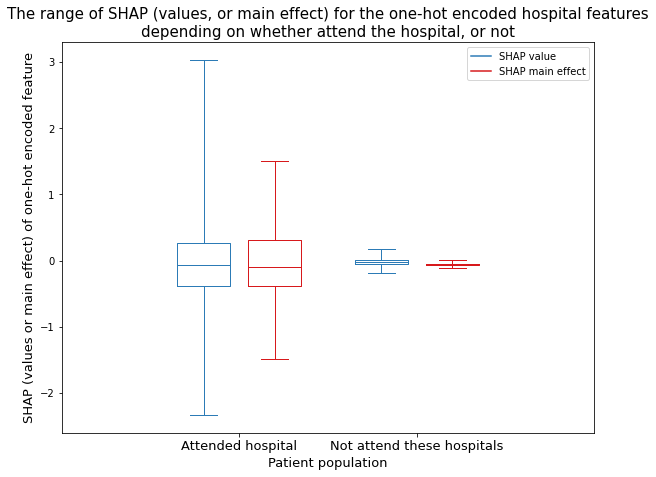

In [27]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(1,1,1)

# 
ticks = ["Attended hospital", "Not attend these hospitals"]

plot_data_sv = [df_hosp_shap_values["Attended stroke team"], 
                df_hosp_shap_values["Not attended stroke teams"]]

# colors (#2C7BB6 & #D7191C) are from http://colorbrewer2.org/
bp_sv = plt.boxplot(plot_data_sv, 
                  positions=np.array(range(len(plot_data_sv)))*2.0-0.4, 
                  sym='', whis=99999, widths=0.6)
set_box_color(bp_sv, '#2C7BB6')

plot_data_me = [df_hosp_shap_main_effects["Attended stroke team"], 
                df_hosp_shap_main_effects["Not attended stroke teams"]]
bp_me = plt.boxplot(plot_data_me, 
                  positions=np.array(range(len(plot_data_me)))*2.0+0.4, 
                  sym='', whis=99999, widths=0.6)
set_box_color(bp_me, '#D7191C')

# draw temporary red and blue lines and use them to create a legend
plt.plot([], c='#2C7BB6', label='SHAP value')
plt.plot([], c='#D7191C', label='SHAP main effect')
plt.legend()

plt.xticks(range(0, len(ticks) * 2, 2), ticks, size=13)
plt.xlim(-2, len(ticks)*2)
plt.tight_layout()

title = ("The range of SHAP (values, or main effect) for the one-hot encoded "
         "hospital features\ndepending on whether attend the hospital, or not")
plt.title(title, size=15)
plt.ylabel('SHAP (values or main effect) of one-hot encoded feature', size=13)
plt.xlabel('Patient population', size=13)
plt.savefig(f'./output/{notebook}_{model_text}'
            f'_hosp_shap_value_and_maineffect_attend_vs_notattend_boxplot.jpg', 
            dpi=300, bbox_inches='tight', pad_inches=0.2)
plt.show()

### Boxplot (individual hospitals)
Create a boxplot to show the range of SHAP values and SHAP main effect values for each individual one-hot encoded hospital feature.

Order the hospitals in descending order of median SHAP main effect value for the attended hospital (so those that more often contribute to a yes-thrombolysis decision, through to those that most often contribute to a no-thrombolysis decision).

Firstly, to order the hospitals, create a dataframe containing the median SHAP main effect, and median SHAP values for each hosptial (for those instances that attended the hospital).

In [28]:
def shap_descriptive_stats(hospital_names, df_hosp_shap, suffix_text):
    """
    hospital_names [list]: list of hospital names (in df_hosp_shap column 
                           "Stroke team")
    df_hosp_shap [dataframe]: Contains patient data per row, and hosptial team 
                            per column, plus a column "Stroke team" stating the 
                            hospital the patient attended
    suffix_text [string]: Add to hardcoded column name
    
    return df [dataframe]: Hospital per row, statistic per column
    """
    # Initialise empty lists
    attend_stroketeam_min = []
    attend_stroketeam_q1 = []
    attend_stroketeam_median = []
    attend_stroketeam_q3 = []
    attend_stroketeam_max = []
    
    # For each hospital
    for h in hospital_names:
        # Extract the patients that attend this hosptial
        mask = df_hosp_shap['Stroke team'] == h
        data_stroke_team = df_hosp_shap[h][mask]
        # Calculate and store the descriptive stats
        q1, q3 = np.percentile(data_stroke_team, [25,75])
        attend_stroketeam_min.append(data_stroke_team.min())
        attend_stroketeam_q1.append(q1)
        attend_stroketeam_median.append(data_stroke_team.median())
        attend_stroketeam_q3.append(q3)
        attend_stroketeam_max.append(data_stroke_team.max())

    
    # Create dataframe to store the descriptive stats.
    # Has six columns (hospital and five descriptive stats)
    df = pd.DataFrame(hospital_names, columns=[f"hospital_{suffix_text}"])
    df[f"shap_min_{suffix_text}"] = attend_stroketeam_min
    df[f"shap_q1_{suffix_text}"] = attend_stroketeam_q1
    df[f"shap_median_{suffix_text}"] = attend_stroketeam_median
    df[f"shap_q3_{suffix_text}"] = attend_stroketeam_q3
    df[f"shap_max_{suffix_text}"] = attend_stroketeam_max
    
    # Return the dataframe
    return(df)

For the SHAP values and the SHAP main effects, calculate the descriptive statistics for each individual hospital.

In [29]:
# Call function to calculate the descriptive statistics (returns a dataframe)
df_me = shap_descriptive_stats(hospitals, df_hosp_shap_main_effects, "me")
df_sv = shap_descriptive_stats(hospitals, df_hosp_shap_values, "sv")

# Join the two sets of data: SHAP values and SHAP main effect
df_hosp_shap_descriptive_stats = df_me.join(df_sv)
df_hosp_shap_descriptive_stats.drop(columns=["hospital_sv"], inplace=True)
df_hosp_shap_descriptive_stats.rename(columns={"hospital_me": "hospital"}, 
                                      inplace=True)

Sort hospitals in descending SHAP main effect value order. Those with higher disposition to thrombolyse at top, those with least disposition to thrombolyse at bottom.

In [30]:
df_hosp_shap_descriptive_stats.sort_values("shap_median_me", 
                                           ascending=False, inplace=True)                
df_hosp_shap_descriptive_stats.head(5)

,hospital,shap_min_me,shap_q1_me,shap_median_me,shap_q3_me,shap_max_me,shap_min_sv,shap_q1_sv,shap_median_sv,shap_q3_sv,shap_max_sv
9,CNBGF2713O,1.143097,1.336121,1.353682,1.381485,1.452963,0.425573,0.774547,0.936063,1.235119,1.616464
99,TPXYE0168D,0.766720,1.015403,1.077394,1.144115,1.404156,-0.171987,0.467067,0.869252,1.218372,2.145683
25,GKONI0110I,0.767692,1.011020,1.051741,1.081380,1.361163,0.065042,0.764047,1.005937,1.169255,2.042346
32,HPWIF9956L,0.701258,0.896796,0.956693,1.032161,1.332165,-0.025544,0.736911,1.187192,1.480586,2.077968
62,MHMYL4920B,0.681638,0.891081,0.918488,0.952453,1.099089,-0.018845,0.647872,0.810736,0.944418,1.640207


Create data for boxplot. Use the SHAP values and SHAP main effects per attended hosptial (obtained from teh fitted model fo rhte 10k cohort) for the boxplot. Use the models predicted 10k thrombolysis rate for each individual hospital as part of the x axis label.

In [31]:
# Specify hosptial order for boxplot
hospital_order = df_hosp_shap_descriptive_stats["hospital"]
    
# Initiate empty lists
me_attend_stroketeam_groups_ordered = []
sv_attend_stroketeam_groups_ordered = [] 
me_not_attend_stroketeam_groups_ordered = []
sv_not_attend_stroketeam_groups_ordered = []
# Create list of labels for boxplot "stroke team name (admissions)"
xlabel = []

# Through hospital in defined order (as determined above)
for h in hospital_order:

    # Mask of patients attend hosptial
    mask = df_hosp_shap_main_effects['Stroke team'] == h
    # Create list of the SHAP main effect values for instances that attend each
    #   stroke team
    me_attend_stroketeam_groups_ordered.append(
                                            df_hosp_shap_main_effects[h][mask])
    
    # Mask of patients attend hosptial
    mask = df_hosp_shap_values['Stroke team'] == h
    # Create list of the SHAP values for instances that attend each stroke team
    sv_attend_stroketeam_groups_ordered.append(df_hosp_shap_values[h][mask])

    # X axis tick label
    xlabel.append(f"{h} ({round(df_10k_thrombolysis_by_hosp['Thrombolysis rate'].loc[h] * 100, 0)}%)")

Resource for using overall y min and max of both datasets on the 4 plots so have the same range https://blog.finxter.com/how-to-find-the-minimum-of-a-list-of-lists-in-python/#:~:text=With%20the%20key%20argument%20of,of%20the%20list%20of%20lists.

Shows the range of contributions to the prediction from this hospital when patients attend this hosptial


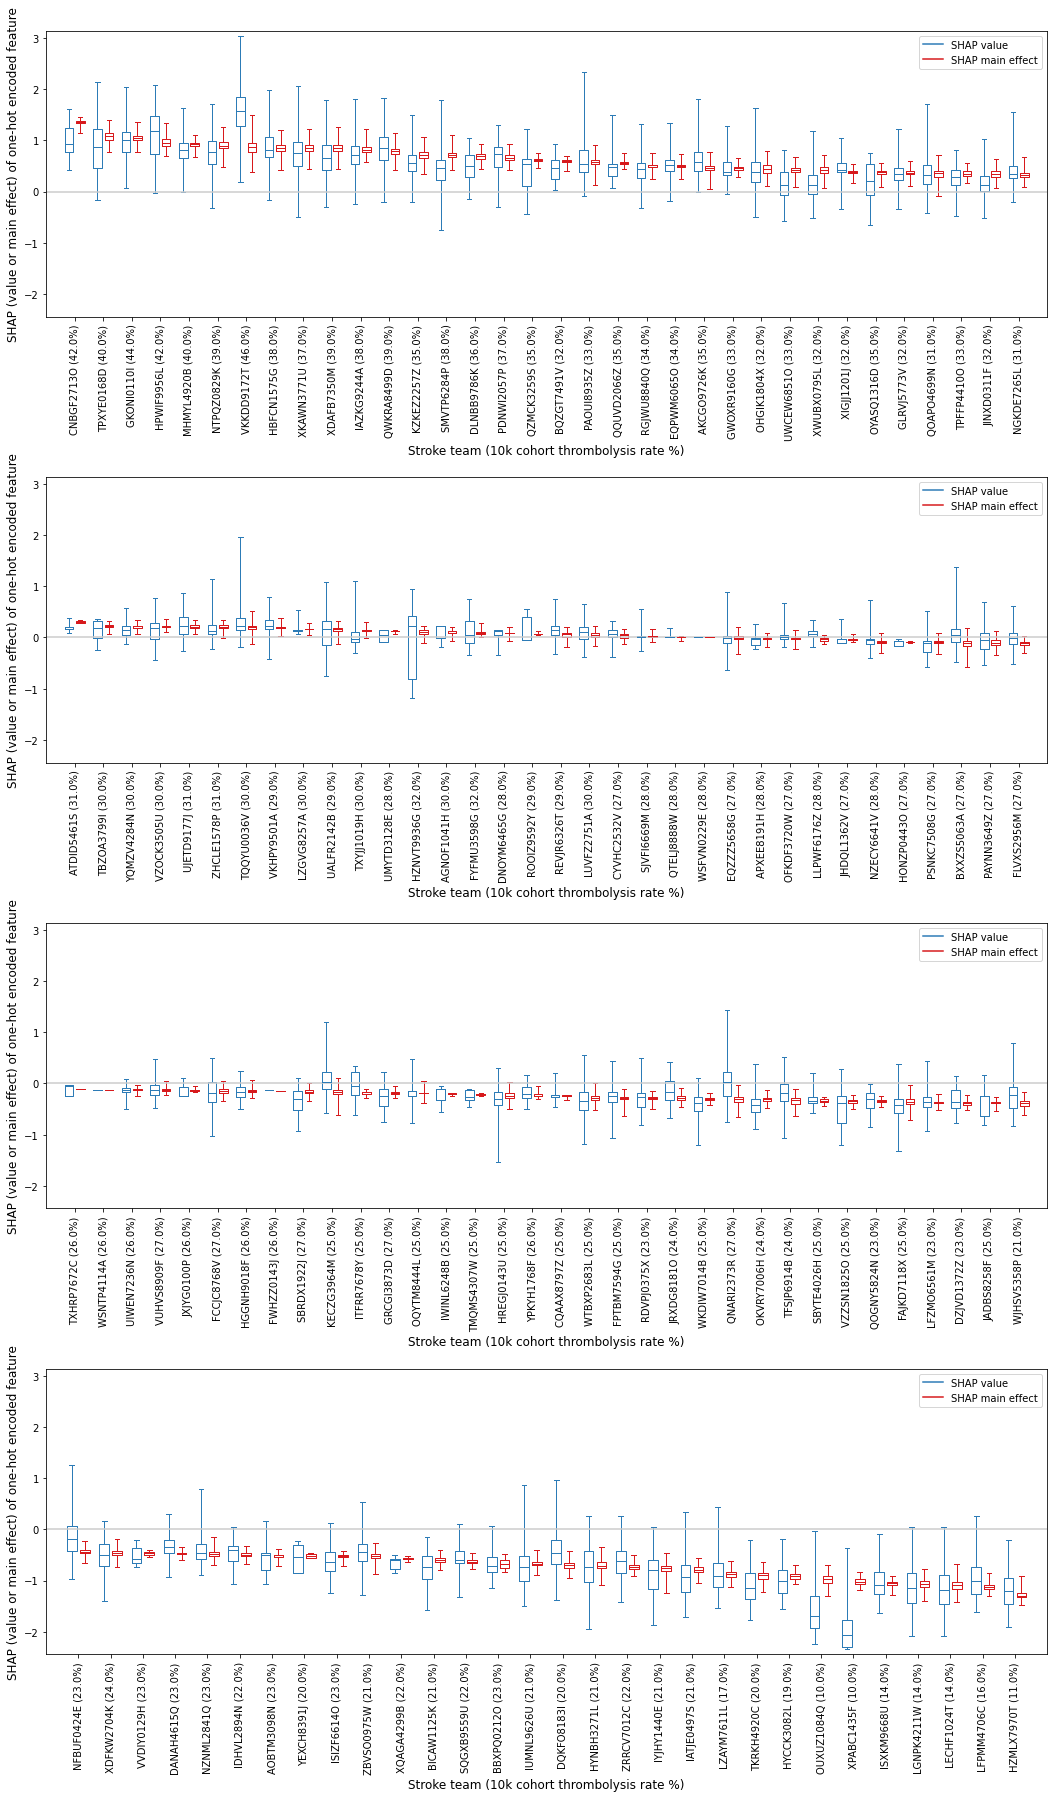

In [32]:
# Plot 34 hospitals on each figure to aid visually
print("Shows the range of contributions to the prediction from this hospital "
      "when patients attend this hosptial")

# To group the hospitals into 34
st = 0
ed = 34
inc = ed
max_size = len(hospitals)

# Use overall y min & max of both datasets on the 4 plots so have same range
ymin = min(min(sv_attend_stroketeam_groups_ordered, key=min))
ymax = max(max(sv_attend_stroketeam_groups_ordered, key=max))

# Adjust min and max to accommodate some wriggle room
yrange = ymax - ymin
ymin = ymin - yrange/50
ymax = ymax + yrange/50

# Create figure with 4 subplots
fig = plt.figure(figsize=(15,25))

# Create four subplots
for subplot in range(4):
    # Create subplot
    ax = fig.add_subplot(4,1,subplot+1)
    
    # x tick labels for the hospital in this subplot
    ticks = xlabel[st:ed]
    
    # Plot SHAP value boxplots
    pos_sv = np.array(range(
                    len(sv_attend_stroketeam_groups_ordered[st:ed])))*2.0-0.4
    bp_sv = plt.boxplot(sv_attend_stroketeam_groups_ordered[st:ed], 
                        positions=pos_sv, sym='', whis=99999, widths=0.6)
    
    # Plot SHAP main effect boxplots
    pos_me = np.array(range(len(
                        me_attend_stroketeam_groups_ordered[st:ed])))*2.0+0.4
    bp_me = plt.boxplot(me_attend_stroketeam_groups_ordered[st:ed], 
                        positions=pos_me, sym='', whis=99999, widths=0.6)
    
    # colors are from http://colorbrewer2.org/
    set_box_color(bp_me, '#D7191C') 
    set_box_color(bp_sv, '#2C7BB6')

    # draw temporary red and blue lines and use them to create a legend
    plt.plot([], c='#2C7BB6', label='SHAP value')
    plt.plot([], c='#D7191C', label='SHAP main effect')
    plt.legend()

    plt.xticks(range(0, len(ticks) * 2, 2), ticks)
    plt.xlim(-2, len(ticks)*2)
    plt.ylim(ymin, ymax)
    plt.tight_layout()
    
    # Add line at Shap = 0
    plt.plot([plt.xlim()[0], plt.xlim()[1]], [0,0], c='0.8') 
    
    plt.ylabel('SHAP (value or main effect) of one-hot encoded feature', 
               size=12)
    plt.xlabel('Stroke team (10k cohort thrombolysis rate %)', size=12)
    plt.xticks(rotation=90)
    st = min(st+inc,max_size)
    ed = min(ed+inc,max_size)
    
plt.subplots_adjust(bottom=0.25, wspace=0.05)    
plt.tight_layout(pad=2)
plt.savefig(f'./output/{notebook}_{model_text}_individual_hosp_shap_value_and_'
            f'maineffect_boxplot.jpg', dpi=300, 
            bbox_inches='tight', pad_inches=0.2)
plt.show()

### Compare hosptial SHAP value (and SHAP main effect) with 10k thrombolysis rate

Get median SHAP (value, and main effect) for each hospital (for 10k cohort attending that hospital)

In [33]:
# Initialise empty lists
hospital_mean_shap_value = []
hospital_mean_shap_me = []

# For each hospital
for i in range(len(hospital_order)):
    # Calculate median SHAP main effect and SHAP value
    hospital_mean_shap_value.append(
                            np.median(sv_attend_stroketeam_groups_ordered[i]))
    hospital_mean_shap_me.append(
                            np.median(me_attend_stroketeam_groups_ordered[i]))

# Create and store in a dataframe
df_hospital_shap = pd.DataFrame(index=hospital_order)
df_hospital_shap['mean SHAP value'] = hospital_mean_shap_value
df_hospital_shap['mean SHAP main effect'] = hospital_mean_shap_me

Combine with 10k cohort thrombolysis rate at that hospital.

In [34]:
df_hosp_plot = df_10k_thrombolysis_by_hosp.merge(
                    df_hospital_shap, left_index=True, right_index=True)

In [35]:
df_hosp_plot.head()

,Thrombolysis rate,mean SHAP value,mean SHAP main effect
VKKDD9172T,0.4610,1.568266,0.861947
GKONI0110I,0.4356,1.005937,1.051741
CNBGF2713O,0.4207,0.936063,1.353682
HPWIF9956L,0.4191,1.187192,0.956693
MHMYL4920B,0.3981,0.810736,0.918488


Show histogram of the frequency of median SHAP value (or median SHAP main effect) across the 132 hospitals.

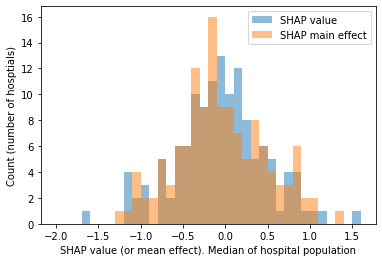

In [36]:
import random
import numpy
from matplotlib import pyplot

x = df_hosp_plot["mean SHAP value"]
y = df_hosp_plot["mean SHAP main effect"]

bins = np.arange(-2.0, 1.7, 0.1)

plt.hist(x, bins, alpha=0.5, label='SHAP value')
plt.hist(y, bins, alpha=0.5, label='SHAP main effect')
plt.legend(loc='upper right')
plt.ylabel('Count (number of hosptials)')
plt.xlabel('SHAP value (or mean effect). Median of hospital population')
plt.savefig(f'./output/{notebook}_{model_text}_hosp_shap_value_and_main_effect_hist.jpg', dpi=300,
    bbox_inches='tight', pad_inches=0.2)
plt.show()

Plot scatter plot of comparison between average hospital SHAP value and predicted 10k thrombolysis use. (and average SHAP main effect with predicted 10k thrombolysis use).

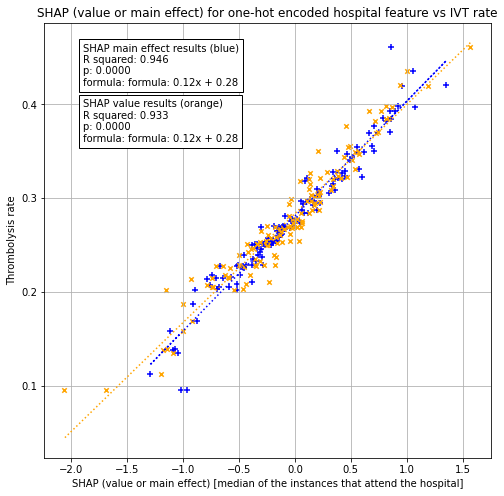

In [37]:
# Setup data for chart
x1 = df_hosp_plot['mean SHAP main effect']
x2 = df_hosp_plot['mean SHAP value']
y = df_hosp_plot['Thrombolysis rate']

# Fit a regression line to the x1 points
slope1, intercept1, r_value1, p_value1, std_err1 = \
    stats.linregress(x1, y)
r_square1 = r_value1 ** 2
y_pred1 = intercept1 + (x1 * slope1)

# Fit a regression line to the x2 points
slope2, intercept2, r_value2, p_value2, std_err2 = \
    stats.linregress(x2, y)
r_square2 = r_value2 ** 2
y_pred2 = intercept2 + (x2 * slope2)

# Create scatter plot with regression line
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1)
ax.scatter(x1, y, color = "blue", marker="+", s=30)
ax.scatter(x2, y, color = "orange", marker="x", s=20)

ax.plot (x1, y_pred1, color = 'blue', linestyle=':')
f1 = ('formula: ' + str("{:.2f}".format(slope1)) + 'x + ' + 
      str("{:.2f}".format(intercept1)))
text1 = (f'SHAP main effect results (blue)\nR squared: {r_square1:.3f}\np: '
         f'{p_value1:0.4f}\nformula: {f1}')
ax.text(-1.9, 0.42, text1, 
         bbox=dict(facecolor='white', edgecolor='black'))

ax.plot (x2, y_pred2, color = 'orange', linestyle=':')
f2 = ('formula: ' + str("{:.2f}".format(slope2)) + 'x + ' + 
      str("{:.2f}".format(intercept2)))
text2 = (f'SHAP value results (orange)\nR squared: {r_square2:.3f}\np: '
         f'{p_value2:0.4f}\nformula: {f2}')
ax.text(-1.9, 0.36, text2, 
         bbox=dict(facecolor='white', edgecolor='black'))

ax.set_xlabel("SHAP (value or main effect) "
              "[median of the instances that attend the hospital]")
ax.set_ylabel('Thrombolysis rate')
ax.set_title("SHAP (value or main effect) for one-hot encoded hospital feature "
             "vs IVT rate")
plt.grid()

plt.savefig(f'./output/{notebook}_{model_text}'
            f'_attended_hosp_shap_value_and_maineffect_vs_ivt_rate.jpg', 
            dpi=300, bbox_inches='tight', pad_inches=0.2)
plt.show()
